In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

# Motivation

[News](http://www.wsj.com/articles/oil-at-seven-month-high-as-u-s-stockpiles-drop-1464168624) [articles](http://www.marketwatch.com/story/oil-prices-march-past-50-amid-signs-of-us-inventory-falls-2016-06-08) love citing the crude inventory as reasons for movements in oil prices. Quoting from the WSJ:

> U.S. inventories are closely watched by traders as the first indicator of the global supply-and-demand balance. Stockpiles have fallen in recent weeks from their highest level in more than 80 years, boosting expectations that the global glut of crude that has weighed on prices for nearly two years is now receding.

> The U.S. Energy Information Administration said U.S. crude stockpiles fell 4.2 million barrels last week, while analysts polled by The Wall Street Journal had expected a decrease of 2.5 million barrels.

So this got me really curious. How good is the Energy Information Administration (EIA) figure as a predictor of crude oil prices? To test this, I decided to use the following data:

1. EIA US Crude Inventory ex-SPR (Strategic Petroleum Reserve). This data (basically the one that WSJ quoted on top) is **usually released every Wednesday afternoon**. This data is going to be a single number for every week.
2. US Oil Fund (USO), an ETF that tracks the front month West Texas Intermediate (WTI) futures. This is going to be a set of numbers daily describing the **open, high, low, close** (OHLC) prices. We are most interested in the extent of movement from the beginning of the day (before EIA data is released) to the end of the day (after EIA data is released). Hence, we define **intraday return** as **(close - open) / close** for a specific day. Furthermore, we are probably interested in this figure for **Wednesdays** given that EIA data is released every Wednesday.

# Data

I pull the data from Thomson Datastream using this [wonderful Python interface](https://github.com/vfilimonov/pydatastream). If you want to replicate this, you'd need to get yourself some Datastream credentials. Ask your school librarian very nicely. :)

In [2]:
import pydatastream
from pydatastream import Datastream
import os
import csv
import pandas
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.formula.api as sm

credentials = {}
with open('credentials.txt', 'r') as credentials_file:
    line = credentials_file.readline().split(',')
    credentials['username'] = line[0]
    credentials['password'] = line[1]

DWE = Datastream(username=credentials['username'], password=credentials['password'])
DWE.raise_on_error = False

The crude oil inventory data has the datastream mnemonic `EIA2007` (trust me it took me like 2 hours to find it.) Then I plot it to inject some pictures into this post (otherwise you'd find it boring right?) Besides everyone likes pictures.

In [3]:
crude_oil_stock = DWE.fetch(['EIA2007'], date_from='2000-01-01', freq='D')
uso = DWE.get_OHLC('U:USO', date_from='2000-01-01')

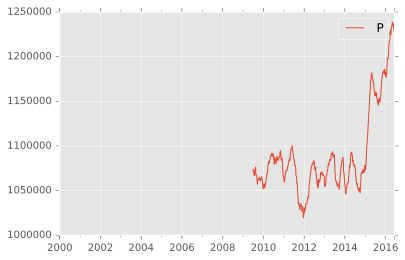

In [4]:
crude_oil_stock.plot()

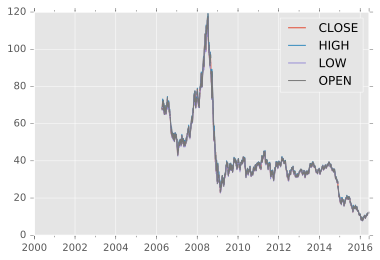

In [5]:
uso.plot()

Uh oh looks like we don't have complete data before late 2009. Oh well. We just truncate our analysis then.

Now let's subdivide our data into each of the days of the week: Monday till Friday.

Also, Thomson Datastream's crude oil stock data seems to be lagged by 2 days. That is, Wednesday's data seems to only be in the system by Friday. Hence, I shift the inventory data by `-2` days.

In [6]:
data = crude_oil_stock.merge(uso, left_index=True, right_index=True)
data.columns=['crude_oil_stock', 'uso_close', 'uso_high', 'uso_low', 'uso_open']
data['dayofweek'] = data.index.dayofweek
data['crude_oil_stock'] = data['crude_oil_stock'].shift(-2)
data = data.dropna()

data_daily = {}
for dayofweek in range(0, 5):
    data_daily[dayofweek] = data[data.index.dayofweek == dayofweek]
    data_daily[dayofweek]['uso_intraday_return'] = (data_daily[dayofweek]['uso_close'] - data_daily[dayofweek]['uso_open']) / data_daily[dayofweek]['uso_open']
    data_daily[dayofweek]['crude_oil_stock_pct'] = data_daily[dayofweek]['crude_oil_stock'].pct_change()
    data_daily[dayofweek]['crude_oil_stock_diff'] = data_daily[dayofweek]['crude_oil_stock'].diff()
    data_daily[dayofweek] = data_daily[dayofweek].dropna()

/Users/linanqiu/.virtualenv/default/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/linanqiu/.virtualenv/default/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/linanqiu/.virtualenv/default/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Now we can see how Wednesday's data looks like. We have all the fields that we need for our analysis. They should be pretty self explanatory.

In [9]:
data_daily[2].head(5)

,crude_oil_stock,uso_close,uso_high,uso_low,uso_open,dayofweek,uso_intraday_return,crude_oil_stock_pct,crude_oil_stock_diff
2009-07-01,1070715.0,37.46,38.87,37.08,38.70,2,-0.032041,-0.002698,-2897.0
2009-07-08,1068582.0,32.57,33.65,32.50,33.63,2,-0.031519,-0.001992,-2133.0
2009-07-15,1066785.0,33.47,33.56,32.57,32.90,2,0.017325,-0.001682,-1797.0
2009-07-22,1071936.0,34.81,34.98,33.93,34.01,2,0.023522,0.004829,5151.0
2009-07-29,1073606.0,33.47,34.98,33.36,34.92,2,-0.041523,0.001558,1670.0


# Analysis

First we do scatter plots of `crude_oil_stock_pct`, the percent change of this week's crude inventory stock on last week's inventory stock, on `uso_intraday_return`, the intraday return. Turns out not much of a relationship exists:

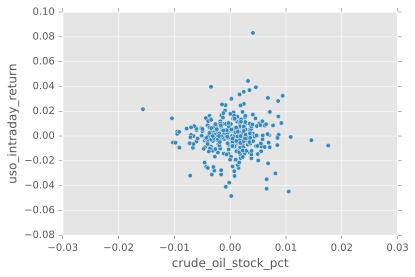

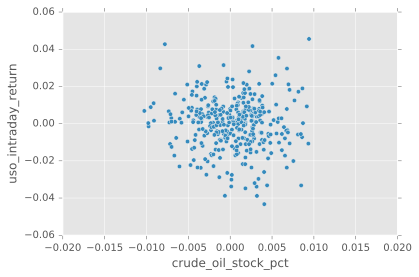

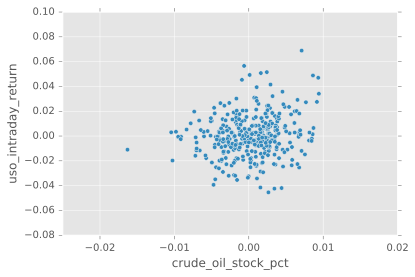

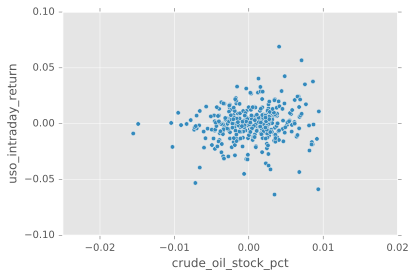

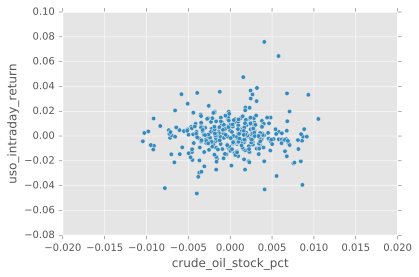

In [15]:
for dayofweek in range(0, 5):
    data_daily[dayofweek].plot(kind='scatter', x='crude_oil_stock_pct', y='uso_intraday_return')
plt.show()

When I ran OLS regressions on each of them, not only are the R-squared pathetic, the slopes are in entirely wrong direction as well. For example, the slope for Wednesdays is 0.734359432686, which means that oil prices tend to increase intraday when the inventory increases.

In [10]:
for dayofweek in range(0, 5):
    model = sm.ols(formula='uso_intraday_return ~ crude_oil_stock_pct', data=data_daily[dayofweek])
    results = model.fit()
    print('Day Of Week ' + str(dayofweek))
    print('Slope ' + str(results.params.crude_oil_stock_pct))

Day Of Week 0
Slope 0.0959621772799
Day Of Week 1
Slope -0.202762367053
Day Of Week 2
Slope 0.734359432686
Day Of Week 3
Slope 0.482402080895
Day Of Week 4
Slope 0.179556901751


In [12]:
for dayofweek in range(0, 5):
    model = sm.ols(formula='uso_intraday_return ~ crude_oil_stock_pct', data=data_daily[dayofweek])
    results = model.fit()
    print('Day Of Week ' + str(dayofweek))
    print('')
    print(results.summary())

Day Of Week 0

                             OLS Regression Results                            
Dep. Variable:     uso_intraday_return   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.2613
Date:                 Thu, 09 Jun 2016   Prob (F-statistic):              0.610
Time:                         22:34:39   Log-Likelihood:                 932.68
No. Observations:                  329   AIC:                            -1861.
Df Residuals:                      327   BIC:                            -1854.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept

In [18]:
model = sm.ols(formula='uso_intraday_return ~ crude_oil_stock_pct', data=data_daily[1])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     uso_intraday_return   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     1.144
Date:                 Thu, 09 Jun 2016   Prob (F-statistic):              0.285
Time:                         22:10:43   Log-Likelihood:                 1035.4
No. Observations:                  359   AIC:                            -2067.
Df Residuals:                      357   BIC:                            -2059.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.0002      0.001      0.302      0.763        -0.001     0.002
crude_oil_stock_pct    -0.2028      0.190     -1.070      0.285        -0.576     0.170
==============================================================================
Omnibus:                        8.913   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               14.310
Skew:                          -0.117   Prob(JB):                     0.000781
Kurtosis:                       3.950   Cond. No.                         265.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
model = sm.ols(formula='uso_intraday_return ~ crude_oil_stock_pct', data=data_daily[2])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     uso_intraday_return   R-squared:                       0.028
Model:                             OLS   Adj. R-squared:                  0.026
Method:                  Least Squares   F-statistic:                     10.44
Date:                 Thu, 09 Jun 2016   Prob (F-statistic):            0.00134
Time:                         22:10:45   Log-Likelihood:                 963.67
No. Observations:                  359   AIC:                            -1923.
Df Residuals:                      357   BIC:                            -1916.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            4.491e-05      0.001      0.051      0.959        -0.002     0.002
crude_oil_stock_pct     0.7344      0.227      3.232      0.001         0.287     1.181
==============================================================================
Omnibus:                       18.131   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.969
Skew:                           0.335   Prob(JB):                     3.11e-07
Kurtosis:                       4.247   Cond. No.                         260.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
model = sm.ols(formula='uso_intraday_return ~ crude_oil_stock_pct', data=data_daily[3])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     uso_intraday_return   R-squared:                       0.014
Model:                             OLS   Adj. R-squared:                  0.012
Method:                  Least Squares   F-statistic:                     5.126
Date:                 Thu, 09 Jun 2016   Prob (F-statistic):             0.0242
Time:                         22:11:18   Log-Likelihood:                 968.11
No. Observations:                  352   AIC:                            -1932.
Df Residuals:                      350   BIC:                            -1924.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.0004      0.001     -0.500      0.618        -0.002     0.001
crude_oil_stock_pct     0.4824      0.213      2.264      0.024         0.063     0.901
==============================================================================
Omnibus:                       32.562   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.200
Skew:                          -0.274   Prob(JB):                     7.92e-27
Kurtosis:                       5.810   Cond. No.                         258.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
model = sm.ols(formula='uso_intraday_return ~ crude_oil_stock_pct', data=data_daily[4])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     uso_intraday_return   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.8663
Date:                 Thu, 09 Jun 2016   Prob (F-statistic):              0.353
Time:                         22:11:23   Log-Likelihood:                 991.29
No. Observations:                  347   AIC:                            -1979.
Df Residuals:                      345   BIC:                            -1971.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.0009      0.001      1.153      0.250        -0.001     0.002
crude_oil_stock_pct     0.1796      0.193      0.931      0.353        -0.200     0.559
==============================================================================
Omnibus:                       56.151   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.440
Skew:                           0.577   Prob(JB):                     5.61e-56
Kurtosis:                       7.033   Cond. No.                         258.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

EIA inventory data is probably a weak predictor in and of itself. We can add more factors (momentum, etc) but the correlation's definitely not as clear cut as most news agencies would like to claim.